In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence

In [3]:
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False

# [단계 1] 데이터 불러오기

In [7]:
data = pd.read_csv("dataset/melting_tank.csv",engine='python')
data.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


## 시간 및 인덱스 설정

In [8]:
data['STD_DT']=pd.date_range('2020-03-04 0:00', periods=len(data), freq='6S')
data.head(15)  #6초 사이클 타임

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 00:00:00,0,489,116,631,3.19,OK
1,2020-03-04 00:00:06,1,433,78,609,3.19,OK
2,2020-03-04 00:00:12,2,464,154,608,3.19,OK
3,2020-03-04 00:00:18,3,379,212,606,3.19,OK
4,2020-03-04 00:00:24,4,798,1736,604,3.21,OK
5,2020-03-04 00:00:30,5,743,1722,603,3.21,OK
6,2020-03-04 00:00:36,6,390,212,602,3.19,OK
7,2020-03-04 00:00:42,7,493,152,600,3.19,OK
8,2020-03-04 00:00:48,8,427,0,599,3.19,OK
9,2020-03-04 00:00:54,9,489,148,598,3.20,OK


In [9]:
data['STD_DT'] = pd.to_datetime(data['STD_DT']) #시계열 데이터로 전환
data.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 00:00:00,0,489,116,631,3.19,OK
1,2020-03-04 00:00:06,1,433,78,609,3.19,OK
2,2020-03-04 00:00:12,2,464,154,608,3.19,OK
3,2020-03-04 00:00:18,3,379,212,606,3.19,OK
4,2020-03-04 00:00:24,4,798,1736,604,3.21,OK


In [10]:
data.shape

(835200, 7)

## 결측값 확인

In [57]:
data.isnull().sum()  #결측값 확인

INSP           0
MELT_TEMP      0
MELT_WEIGHT    0
MOTORSPEED     0
TAG            0
dtype: int64

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   INSP         835200 non-null  float64
 1   MELT_TEMP    835200 non-null  int64  
 2   MELT_WEIGHT  835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   TAG          835200 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.2+ MB


## 기초통계

In [7]:
data.describe()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000
mean,417599.500000,509.200623,459.782865,582.962125,3.194853
std,241101.616752,128.277519,639.436413,1217.604433,0.011822
min,0.000000,308.000000,0.000000,0.000000,3.170000
25%,208799.750000,430.000000,119.000000,186.000000,3.190000
50%,417599.500000,469.000000,168.000000,383.000000,3.190000
75%,626399.250000,502.000000,218.000000,583.000000,3.200000
max,835199.000000,832.000000,1804.000000,55252.000000,3.230000


## 종속변수 값 변경

In [11]:
data['TAG'][data['TAG']=='NG'] = 1
data['TAG'][data['TAG']=='OK'] = 0

In [8]:
data['TAG'].value_counts()

0    658133
1    177067
Name: TAG, dtype: int64

In [12]:
y1 = data[data['TAG']==1]   #비정상
y0 = data[data['TAG']==0]   #정상

In [10]:
y1.describe()    #비정상

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,177067.000000,177067.000000,177067.000000,177067.000000,177067.000000
mean,377300.340978,432.390112,133.474696,611.327763,3.188640
std,98578.116496,36.431384,67.820548,1240.476980,0.005195
min,188733.000000,308.000000,0.000000,0.000000,3.170000
25%,308244.500000,403.000000,73.000000,200.000000,3.190000
50%,365770.000000,438.000000,141.000000,411.000000,3.190000
75%,444988.500000,457.000000,197.000000,620.000000,3.190000
max,598598.000000,555.000000,270.000000,55252.000000,3.210000


In [11]:
y0.describe()   #정상

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,658133.000000,658133.000000,658133.000000,658133.000000,658133.000000
mean,428441.763176,529.866061,547.574252,575.330509,3.196524
std,265707.743369,136.054454,693.753379,1211.264538,0.012527
min,0.000000,311.000000,0.000000,0.000000,3.170000
25%,164533.000000,443.000000,128.000000,182.000000,3.190000
50%,475175.000000,479.000000,173.000000,376.000000,3.190000
75%,670666.000000,714.000000,1701.000000,573.000000,3.210000
max,835199.000000,832.000000,1804.000000,52727.000000,3.230000


# [단계 2] 데이터 시각화

## 종속변수 시각화 

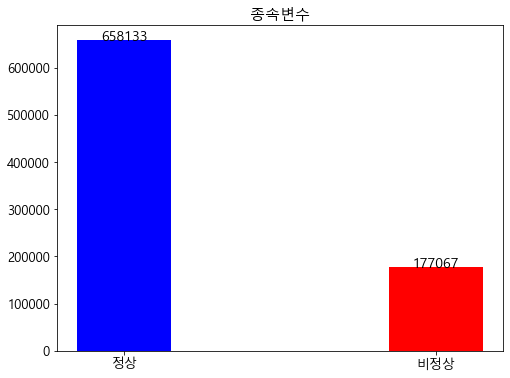

In [15]:
fig,ax = plt.subplots(figsize=(8,6))

x=[0,1]
y=[(data['TAG']==0).sum(),(data['TAG']==1).sum()]


for p in plt.bar(x,y, width=0.3, color=["blue","red"],label=x).patches:
        left, bottom, width, height = p.get_bbox().bounds
        plt.annotate(f"{int(height)}",(left+width/2, height-5), ha = 'center', size =14, color = 'black')
        #plt.annotate(f"{int(height)/100}%",(left+width/2, height-5), ha = 'center', size =14, color = 'black')
plt.title('종속변수',size =15)
plt.xticks(rotation=0)
#plt.xlabel('연도',size =18)
plt.xticks([0,1],['정상','비정상'],size =13)
plt.yticks(size =13)
plt.show()

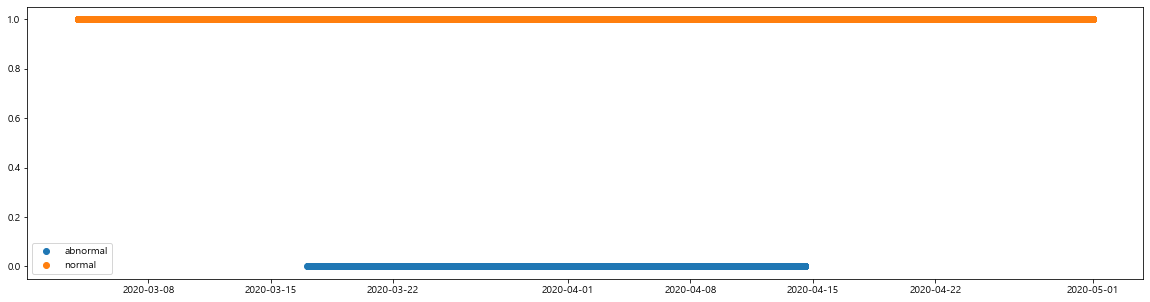

In [29]:
# plt.figure(figsize=(20, 5))     

# y1=data.loc[data['TAG']==0,'TAG']
# y2=data.loc[data['TAG']==1,'TAG']
# # plt.plot(y1.index,y1,label = 'abnormal')  #비정상
# # plt.plot(y2.index,y2,label = 'normal')  #정상

# plt.scatter(y1.index,y1,label = 'abnormal') # , label="class = " + str(int(c)), marker='o', s=5)
# plt.scatter(y2.index,y2,label = 'normal') #, label="class = " + str(int(c)), marker='o', s=5)
    
# #plt.title("sensor_number: {}".format(sensor_number), fontsize=20)
# plt.legend()  
# plt.show()

## 독립변수 시각화 

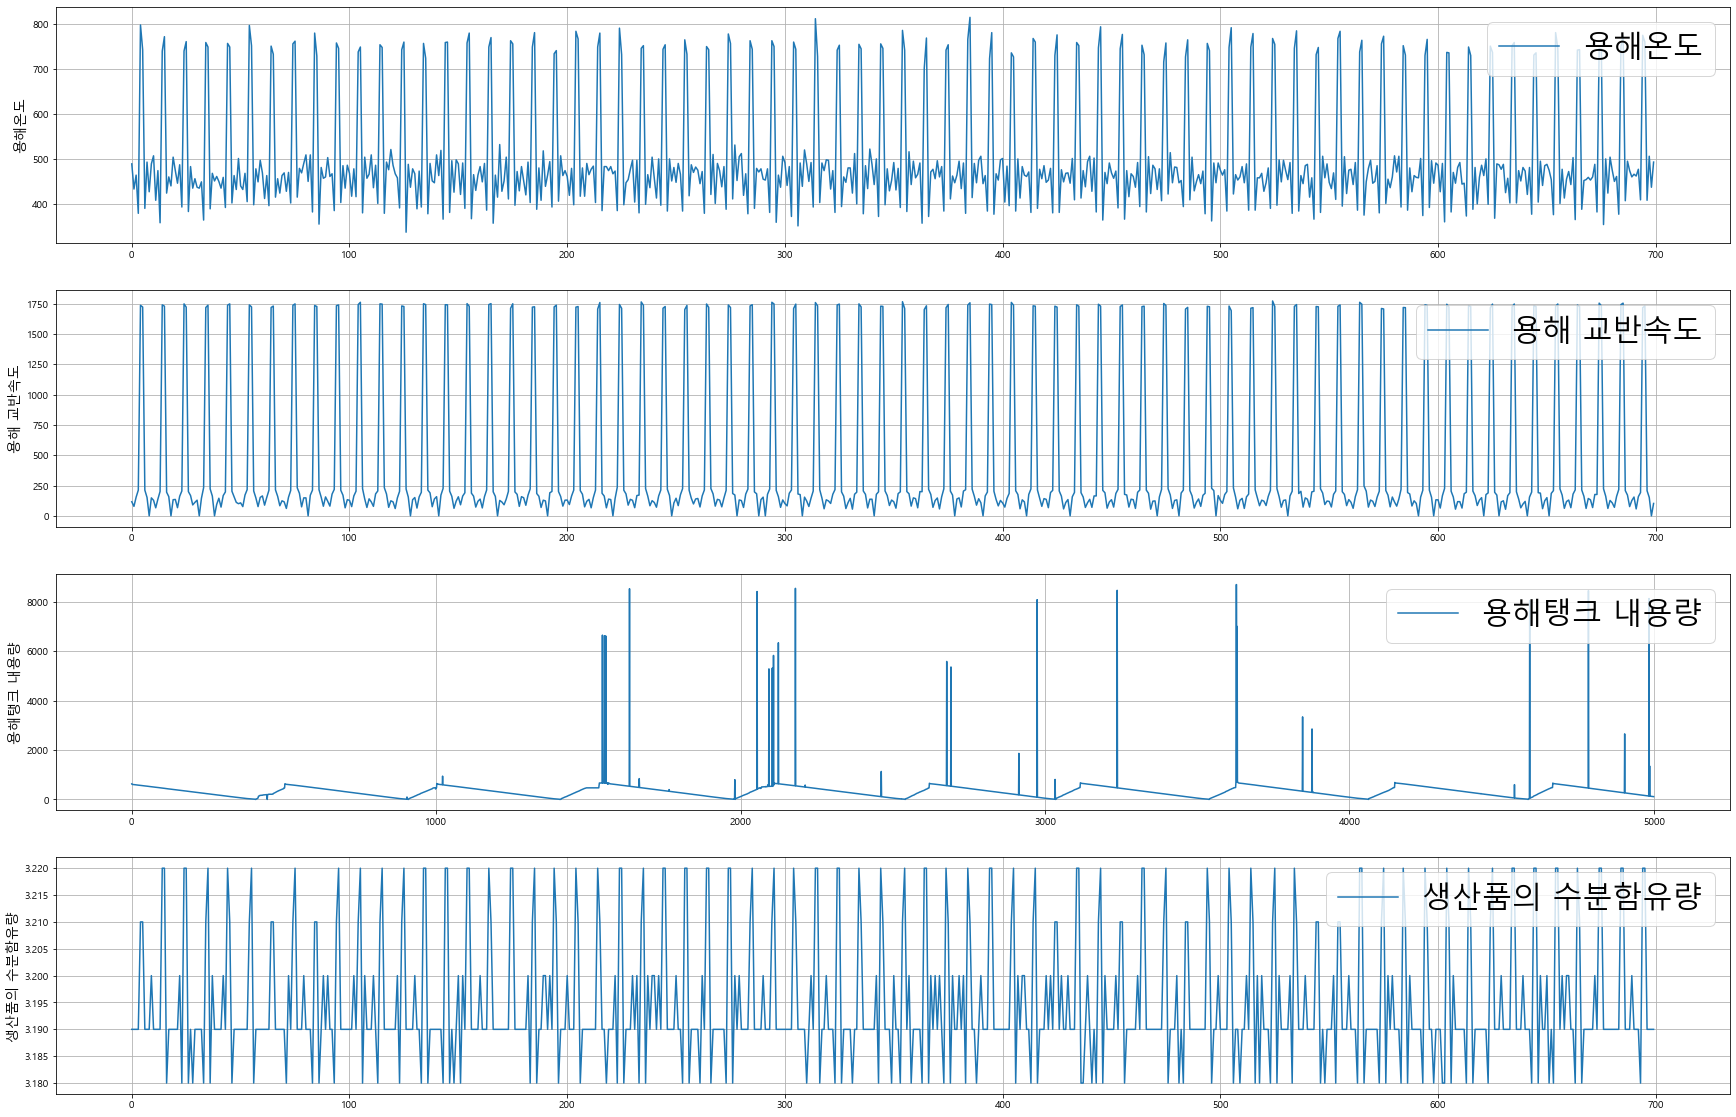

In [20]:
# ground truth & timeseries decompostion all together
# -- observed data
plt.figure(figsize=(30, 20))
plt.subplot(4,1, 1)
data['MELT_TEMP'][:700].plot(label='용해온도')
plt.grid(True)
plt.ylabel('용해온도', fontsize=14)
plt.legend(loc='upper right', fontsize=30)  

# -- trend & cycle factor
plt.subplot(4, 1, 2)
data['MOTORSPEED'][:700].plot(label='용해 교반속도')
plt.grid(True)
plt.ylabel('용해 교반속도', fontsize=14)
plt.legend(loc='upper right', fontsize=30)  

# -- seasonal factor
plt.subplot(4, 1, 3)
data['MELT_WEIGHT'][:5000].plot(label='용해탱크 내용량')
plt.grid(True)
plt.ylabel('용해탱크 내용량', fontsize=14)
plt.legend(loc='upper right', fontsize=30)  

# -- irregular factor (noise)
plt.subplot(4, 1, 4)
data['INSP'][:700].plot(label='생산품의 수분함유량')
plt.grid(True)
plt.ylabel('생산품의 수분함유량', fontsize=14)
plt.legend(loc='upper right', fontsize=30)  

# [단계 3] 데이터 특성 파악

## 시계열 시각화 

원래의 관측치(observed), 추세(trend), 계절성(seasonal), 잔차(residual)

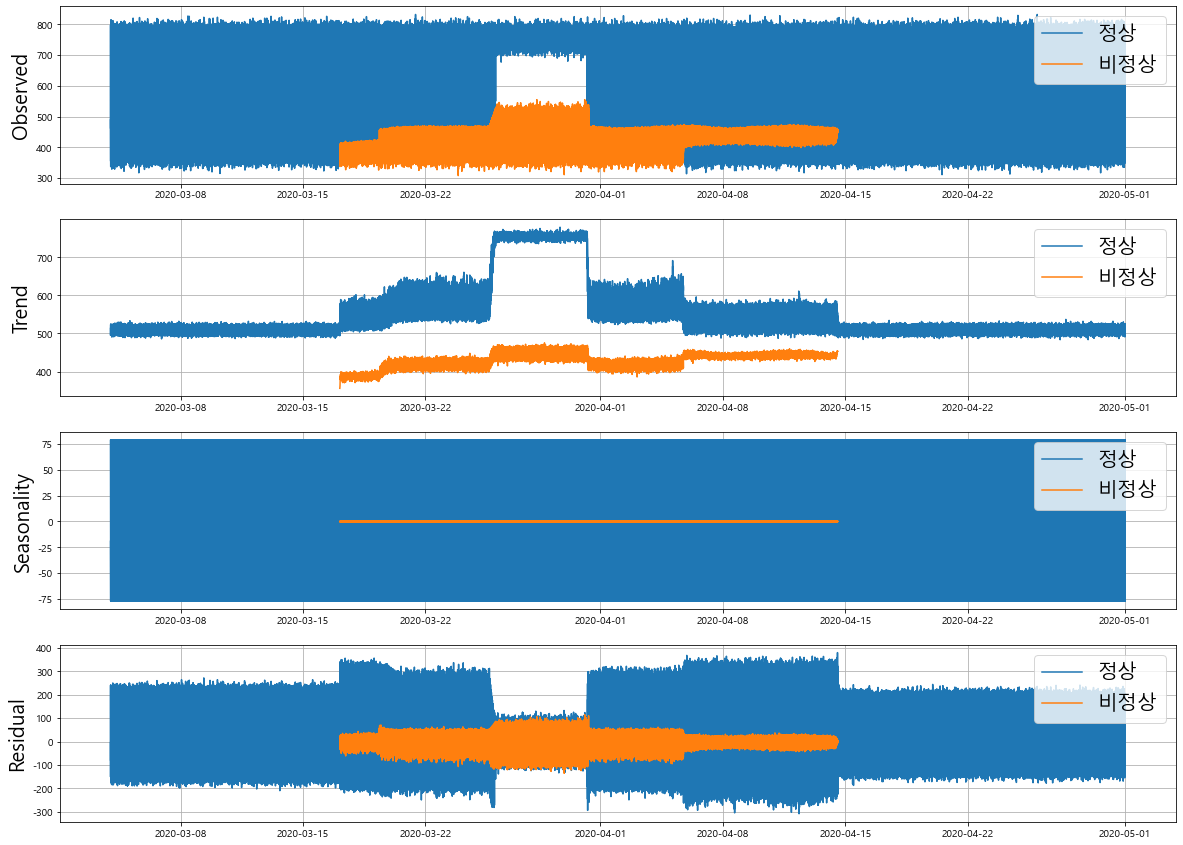

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose    #용해온도



result6 = seasonal_decompose(y0['MELT_TEMP'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq') 

result10 = seasonal_decompose(y1['MELT_TEMP'],period=10, extrapolate_trend='freq',model='additive', two_sided=True) 



# ground truth & timeseries decompostion all together
# -- observed data
plt.figure(figsize=(20, 15))
plt.subplot(4,1, 1)
plt.plot(y0['STD_DT'],result6.observed, label='정상')   
plt.plot(y1['STD_DT'], result10.observed, label='비정상')
plt.grid(True)
plt.ylabel('Observed', fontsize=20)
plt.legend(fontsize=20,loc='upper right')  

# -- trend & cycle factor
plt.subplot(4, 1, 2)
plt.plot(y0['STD_DT'],result6.trend, label='정상')    
plt.plot(y1['STD_DT'], result10.trend, label='비정상')
plt.grid(True)
plt.ylabel('Trend', fontsize=20)
plt.legend(fontsize=20,loc='upper right')  

# -- seasonal factor
plt.subplot(4, 1, 3)
plt.plot(y0['STD_DT'],result6.seasonal, label='정상')
plt.plot(y1['STD_DT'], result10.seasonal, label='비정상')
plt.grid(True)
plt.ylabel('Seasonality', fontsize=20)
plt.legend(fontsize=20,loc='upper right')  

# -- irregular factor (noise)
plt.subplot(4, 1, 4)
plt.plot(y0['STD_DT'],result6.resid, label='정상')
plt.plot(y1['STD_DT'], result10.resid, label='비정상')
plt.grid(True)
plt.ylabel('Residual', fontsize=20)
plt.legend(fontsize=20,loc='upper right')  

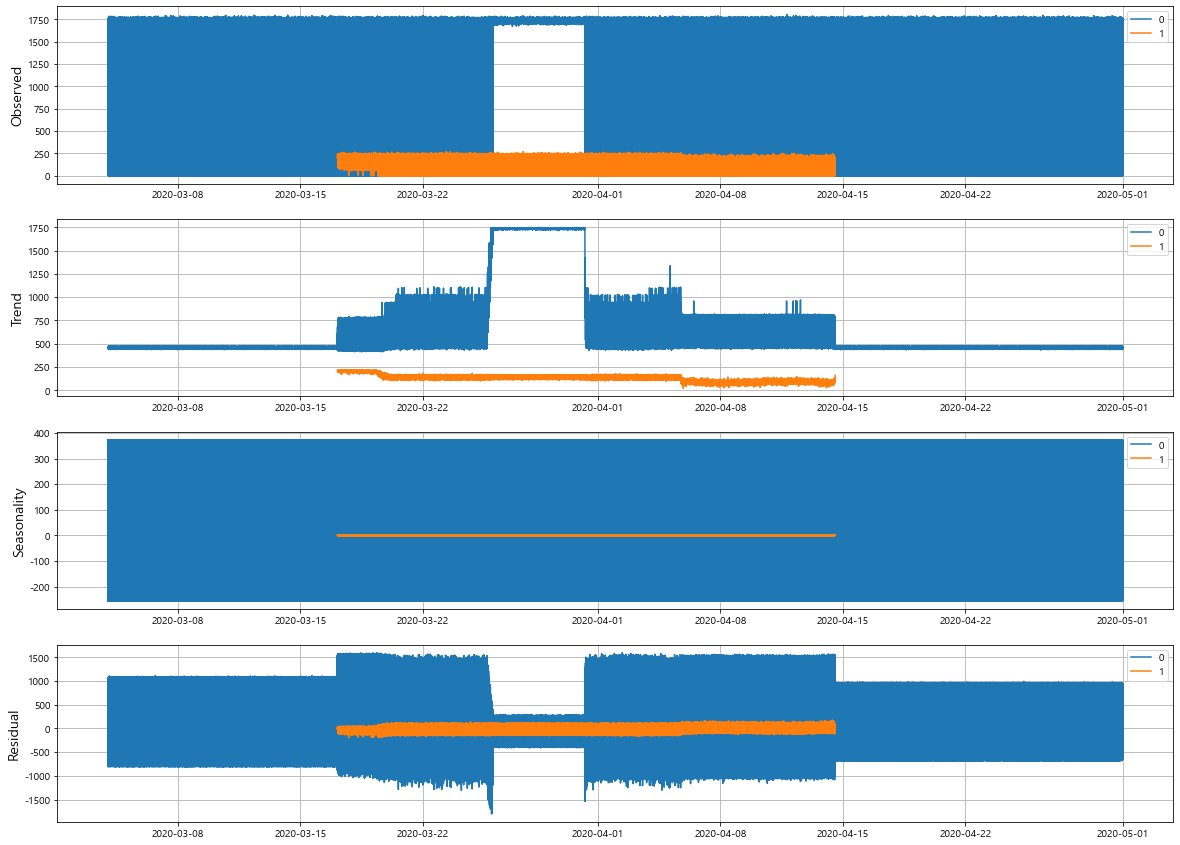

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose   #용해 교반속도


result6 = seasonal_decompose(y0['MOTORSPEED'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq') 

result10 = seasonal_decompose(y1['MOTORSPEED'],period=10, extrapolate_trend='freq',model='additive', two_sided=True) 



# ground truth & timeseries decompostion all together
# -- observed data
plt.figure(figsize=(20, 15))
plt.subplot(4,1, 1)
plt.plot(y0['STD_DT'],result6.observed, label='0')   
plt.plot(y1['STD_DT'], result10.observed, label='1')
plt.grid(True)
plt.ylabel('Observed', fontsize=14)
plt.legend()  

# -- trend & cycle factor
plt.subplot(4, 1, 2)
plt.plot(y0['STD_DT'],result6.trend, label='0')  
plt.plot(y1['STD_DT'], result10.trend, label='1')
plt.grid(True)
plt.ylabel('Trend', fontsize=14)
plt.legend()  

# -- seasonal factor
plt.subplot(4, 1, 3)
plt.plot(y0['STD_DT'],result6.seasonal, label='0')
plt.plot(y1['STD_DT'], result10.seasonal, label='1')
plt.grid(True)
plt.ylabel('Seasonality', fontsize=14)
plt.legend()  

# -- irregular factor (noise)
plt.subplot(4, 1, 4)
plt.plot(y0['STD_DT'],result6.resid, label='0')
plt.plot(y1['STD_DT'], result10.resid, label='1')
plt.grid(True)
plt.ylabel('Residual', fontsize=14)
plt.legend()  

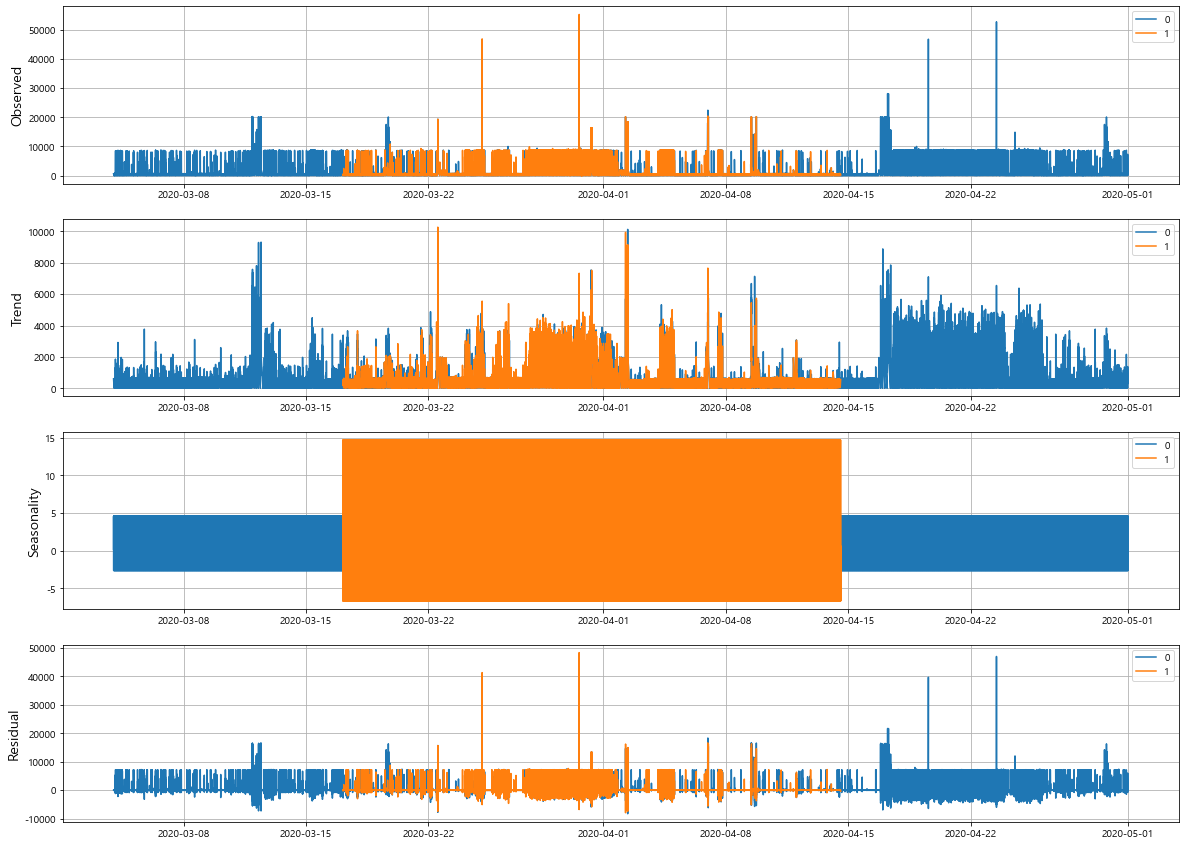

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose   #용해탱크 내용량

result6 = seasonal_decompose(y0['MELT_WEIGHT'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq') 

result10 = seasonal_decompose(y1['MELT_WEIGHT'],period=10, extrapolate_trend='freq',model='additive', two_sided=True) 



# ground truth & timeseries decompostion all together
# -- observed data
plt.figure(figsize=(20, 15))
plt.subplot(4,1, 1)
plt.plot(y0['STD_DT'],result6.observed, label='0')  
plt.plot(y1['STD_DT'], result10.observed, label='1')
plt.grid(True)
plt.ylabel('Observed', fontsize=14)
plt.legend()  

# -- trend & cycle factor
plt.subplot(4, 1, 2)
plt.plot(y0['STD_DT'],result6.trend, label='0')   
plt.plot(y1['STD_DT'], result10.trend, label='1')
plt.grid(True)
plt.ylabel('Trend', fontsize=14)
plt.legend()  

# -- seasonal factor
plt.subplot(4, 1, 3)
plt.plot(y0['STD_DT'],result6.seasonal, label='0')
plt.plot(y1['STD_DT'], result10.seasonal, label='1')
plt.grid(True)
plt.ylabel('Seasonality', fontsize=14)
plt.legend()  

# -- irregular factor (noise)
plt.subplot(4, 1, 4)
plt.plot(y0['STD_DT'],result6.resid, label='0')
plt.plot(y1['STD_DT'], result10.resid, label='1')
plt.grid(True)
plt.ylabel('Residual', fontsize=14)
plt.legend()  

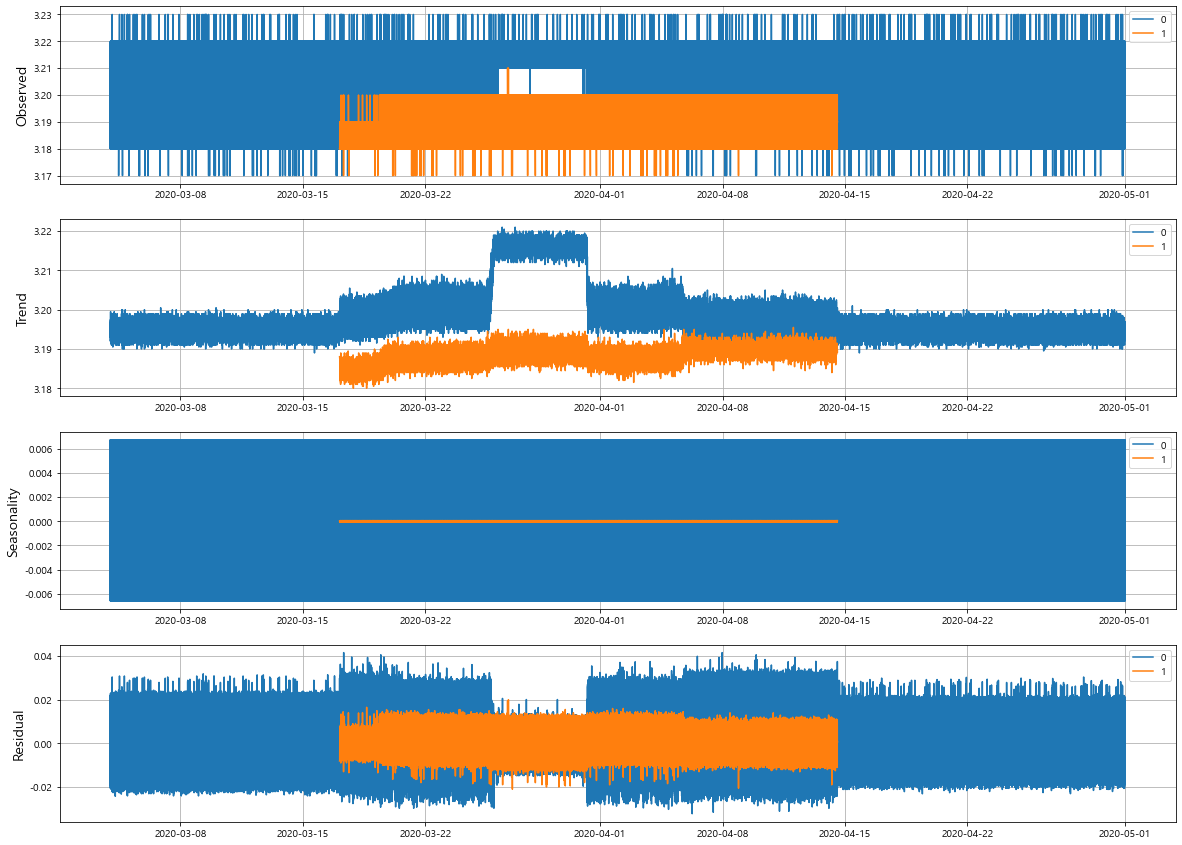

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose   #생산품의 수분함유량



result6 = seasonal_decompose(y0['INSP'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq') 

result10 = seasonal_decompose(y1['INSP'],period=10, extrapolate_trend='freq',model='additive', two_sided=True) 



# ground truth & timeseries decompostion all together
# -- observed data
plt.figure(figsize=(20, 15))
plt.subplot(4,1, 1)
plt.plot(y0['STD_DT'],result6.observed, label='0')   
plt.plot(y1['STD_DT'], result10.observed, label='1')
plt.grid(True)
plt.ylabel('Observed', fontsize=14)
plt.legend()  

# -- trend & cycle factor
plt.subplot(4, 1, 2)
plt.plot(y0['STD_DT'],result6.trend, label='0')   
plt.plot(y1['STD_DT'], result10.trend, label='1')
plt.grid(True)
plt.ylabel('Trend', fontsize=14)
plt.legend()  

# -- seasonal factor
plt.subplot(4, 1, 3)
plt.plot(y0['STD_DT'],result6.seasonal, label='0')
plt.plot(y1['STD_DT'], result10.seasonal, label='1')
plt.grid(True)
plt.ylabel('Seasonality', fontsize=14)
plt.legend()  

# -- irregular factor (noise)
plt.subplot(4, 1, 4)
plt.plot(y0['STD_DT'],result6.resid, label='0')
plt.plot(y1['STD_DT'], result10.resid, label='1')
plt.grid(True)
plt.ylabel('Residual', fontsize=14)
plt.legend()  

# [단계 4] 데이터 전처리

## 데이터 분리

In [21]:
a = y0.copy()
a = a.set_index(['STD_DT']) 
a.head()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04 00:00:00,0,489,116,631,3.19,0
2020-03-04 00:00:06,1,433,78,609,3.19,0
2020-03-04 00:00:12,2,464,154,608,3.19,0
2020-03-04 00:00:18,3,379,212,606,3.19,0
2020-03-04 00:00:24,4,798,1736,604,3.21,0


In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

y0_de1= seasonal_decompose(a['MELT_TEMP'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq').trend
y0_de2= seasonal_decompose(a['MOTORSPEED'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq').trend
# y0_de3= seasonal_decompose(a['MELT_WEIGHT'],period=10, model='additive', two_sided=True,
#                               extrapolate_trend='freq').trend
y0_de4= seasonal_decompose(a['INSP'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq').trend

In [3]:
b = y0_de4   #변경

Q1 = b.quantile(0.25)
Q3 = b.quantile(0.75)
IQR = Q3 - Q1

iqr_out=(b< (Q1 - 4* IQR)) |(b> (Q3 + 4* IQR))
iqr_out[(iqr_out== False)] = 0

iqr_c1 = iqr_out.loc[iqr_out == 1]  #outlier 
iqr_rm=pd.merge(b, iqr_c1 , on = 'STD_DT',how = 'outer')
iqr_rm[iqr_rm.iloc[:,1]==1]=None
iqr_rm=iqr_rm.iloc[:,0]

In [28]:
de1 = iqr_rm[iqr_rm.isnull()].index   #온도

In [34]:
de2 = iqr_rm[iqr_rm.isnull()].index   #교반속도

In [ ]:
# de3 = iqr_rm[iqr_rm.isnull()].index   #내용량

In [40]:
de4 = iqr_rm[iqr_rm.isnull()].index   #수분함유량

In [41]:
de1 = pd.DataFrame(de1)  
de2 = pd.DataFrame(de2)   
#de3 = pd.DataFrame(de3)  
de4 = pd.DataFrame(de4)  

In [91]:
de12 = pd.merge(de1,de2,how='inner',on='STD_DT')
de124 = pd.merge(de12,de4,how='inner',on='STD_DT')
de124.head()

,STD_DT
0,2020-03-25 18:43:30
1,2020-03-25 18:44:24
2,2020-03-25 18:44:30
3,2020-03-25 18:54:42
4,2020-03-25 18:55:24


In [2]:
de124['out']=1
y0_2= pd.merge(y0, de124 , on = 'STD_DT',how = 'outer')
y0_2 = y0_2[y0_2['out'].isnull()]
y0_2 = y0_2[y0_2.columns.difference(['out'])] 

In [47]:
# 정상 데이터   훈련 80% 시험 20%

from sklearn.model_selection import train_test_split

train_y0, test_y0 = train_test_split(y0_2, test_size=0.2, shuffle=False, random_state=3) 

print("train_y0.shape:", train_y0.shape)
print("test_y0.shape:", test_y0.shape)

train_y0.shape: (513994, 7)
test_y0.shape: (128499, 7)


In [48]:
# 정상 데이터   훈련 70%   검증 30%

train_split_y0, valid_split_y0 = train_test_split(train_y0, test_size=0.3, shuffle=False, random_state=3)  #random_state

print("train_split_y0.shape:", train_split_y0.shape)
print("valid_split_y0.shape:", valid_split_y0.shape)

train_split_y0.shape: (359795, 7)
valid_split_y0.shape: (154199, 7)


In [49]:
# 불량 데이터   검증 70%  시험 30%

valid_y1, test_y1 = train_test_split(y1, test_size=0.4, shuffle=False, random_state=3)  #random_state

print("valid_y1.shape:", valid_y1.shape)
print("test_y1.shape:", test_y1.shape)

valid_y1.shape: (106240, 7)
test_y1.shape: (70827, 7)


In [50]:
# 독립변수, 종속변수 분리 
 

x_train_y0 = train_split_y0[train_split_y0.columns.difference(['TAG'])]  #train 정상
y_train_y0 = train_split_y0[['TAG']]

x_valid_y0 = valid_split_y0[valid_split_y0.columns.difference(['TAG'])]  #valid 정상
y_valid_y0 = valid_split_y0[['TAG']]

x_test_y0 = test_y0[test_y0.columns.difference(['TAG'])]  #test 정상
y_test_y0 = test_y0[['TAG']]

x_valid_y1 = valid_y1[valid_y1.columns.difference(['TAG'])]  #valid 비정상
y_valid_y1 = valid_y1[['TAG']]

x_test_y1 = test_y1[test_y1.columns.difference(['TAG'])]  #test 비정상
y_test_y1 = test_y1[['TAG']]


print("x_train_y0.shape:", x_train_y0.shape) #정상
print("x_valid_y0.shape:", x_valid_y0.shape)
print("x_test_y0.shape:", x_test_y0.shape)

print("\nx_valid_y1.shape:", x_valid_y1.shape)  #불량
print("x_test_y1.shape:", x_test_y1.shape)

print("\ny_train_y0.shape:", y_train_y0.shape)  #정상
print("y_valid_y0.shape:", y_valid_y0.shape)
print("y_test_y0.shape:", y_test_y0.shape)

print("\ny_valid_y1.shape:", y_valid_y1.shape)  #불량
print("y_test_y1.shape:", y_test_y1.shape)

x_train_y0.shape: (359795, 6)
x_valid_y0.shape: (154199, 6)
x_test_y0.shape: (128499, 6)

x_valid_y1.shape: (106240, 6)
x_test_y1.shape: (70827, 6)

y_train_y0.shape: (359795, 1)
y_valid_y0.shape: (154199, 1)
y_test_y0.shape: (128499, 1)

y_valid_y1.shape: (106240, 1)
y_test_y1.shape: (70827, 1)


In [51]:
#타입변환

y_train_y0 = y_train_y0.astype('float') 
y_valid_y0 = y_valid_y0.astype('float')
y_test_y0 = y_test_y0.astype('float')

y_valid_y1 = y_valid_y1.astype('float')
y_test_y1 = y_test_y1.astype('float')

## 데이터 정규화

StandardScalar는 데이터를 단위 분산으로 조정함으로써 Outlier에 취약할 수 있는 반면,   
RobustScaler는 Feature 간 같은 스케일을 갖게 되지만 평균과 분산 대신 중간 값(median)과 사분위값(quartile)을 사용함으로써,    
극단값(Outlier)에 영향을 받지 않음

In [53]:
from sklearn.preprocessing import RobustScaler

col = ['INSP', 'MELT_TEMP', 'MELT_WEIGHT','MOTORSPEED']

rscaler_auto = RobustScaler()   #정상 데이터 기준 

rscaler_auto.fit(x_train_y0[col])

x_train_y0_scaled = rscaler_auto.transform(x_train_y0[col])  #trian 정상
x_train_y0_scaled = pd.DataFrame(x_train_y0_scaled,index=x_train_y0.index, columns=col) 
x_train_y0_scaled = pd.concat([x_train_y0[['STD_DT','NUM']], x_train_y0_scaled], axis=1) 

x_valid_y0_scaled = rscaler_auto.transform(x_valid_y0[col])  #valid 정상
x_valid_y0_scaled = pd.DataFrame(x_valid_y0_scaled,index=x_valid_y0.index, columns=col) 
x_valid_y0_scaled = pd.concat([x_valid_y0[['STD_DT','NUM']], x_valid_y0_scaled], axis=1) 

x_test_y0_scaled = rscaler_auto.transform(x_test_y0[col])  #test 정상
x_test_y0_scaled = pd.DataFrame(x_test_y0_scaled,index=x_test_y0.index, columns=col) 
x_test_y0_scaled = pd.concat([x_test_y0[['STD_DT','NUM']], x_test_y0_scaled], axis=1) 


x_valid_y1_scaled = rscaler_auto.transform(x_valid_y1[col])  #valid 불량
x_valid_y1_scaled = pd.DataFrame(x_valid_y1_scaled,index=x_valid_y1.index, columns=col) 
x_valid_y1_scaled = pd.concat([x_valid_y1[['STD_DT','NUM']], x_valid_y1_scaled], axis=1) 

x_test_y1_scaled = rscaler_auto.transform(x_test_y1[col])  #test 불량
x_test_y1_scaled = pd.DataFrame(x_test_y1_scaled,index=x_test_y1.index, columns=col) 
x_test_y1_scaled = pd.concat([x_test_y1[['STD_DT','NUM']], x_test_y1_scaled], axis=1) 

x_train_y0_scaled.head()

,STD_DT,NUM,INSP,MELT_TEMP,MELT_WEIGHT,MOTORSPEED
0,2020-03-04 00:00:00,0,0.0,0.030418,0.766304,-0.034307
1,2020-03-04 00:00:06,1,0.0,-0.182510,0.706522,-0.058450
2,2020-03-04 00:00:12,2,0.0,-0.064639,0.703804,-0.010165
3,2020-03-04 00:00:18,3,0.0,-0.387833,0.698370,0.026684
4,2020-03-04 00:00:24,4,1.0,1.205323,0.692935,0.994917


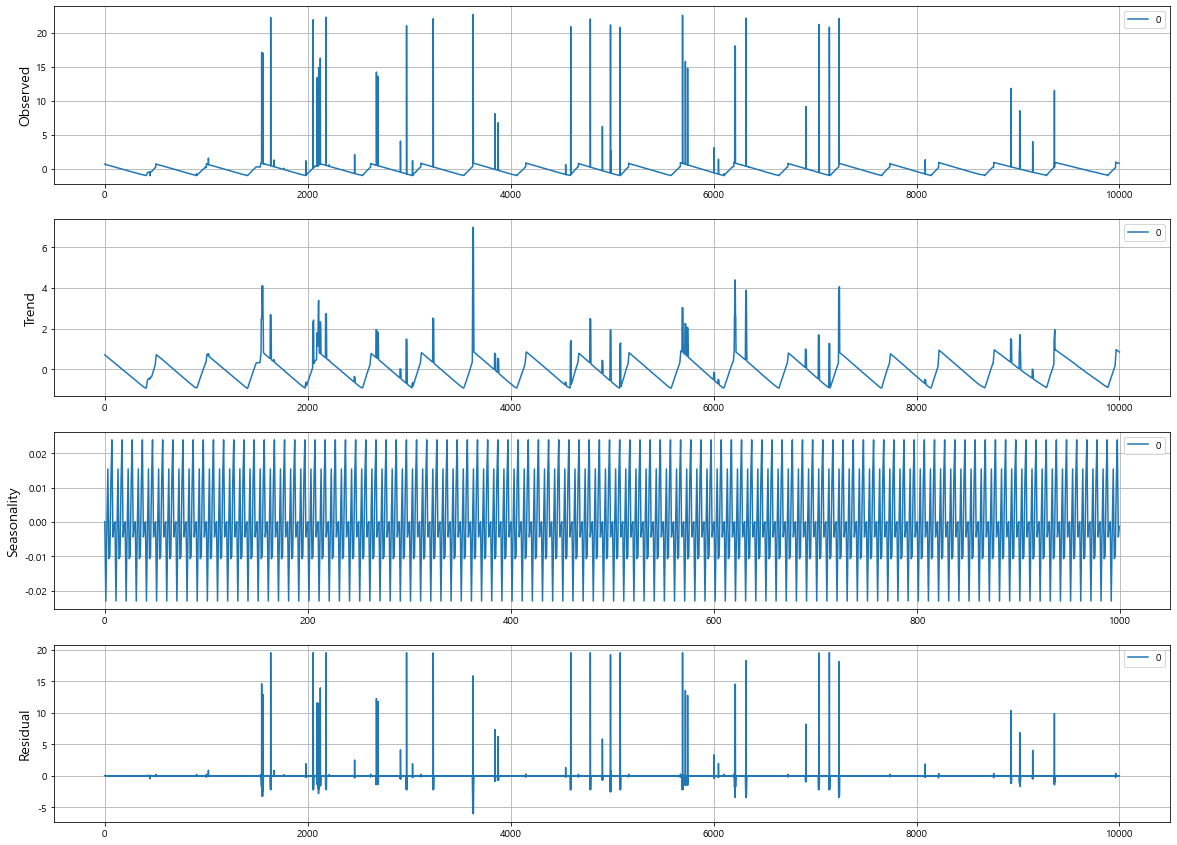

In [54]:
# 정규화 했음에도 불구하고 이상치 데이터가 많이 변수 삭제 

from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(x_train_y0_scaled['MELT_WEIGHT'],period=10, model='additive', two_sided=True,
                              extrapolate_trend='freq') 

# ground truth & timeseries decompostion all together
# -- observed data
plt.figure(figsize=(20, 15))
plt.subplot(4,1, 1)
plt.plot(range(0,len(x_train_y0_scaled))[:10000],result.observed[:10000], label='0')
plt.grid(True)
plt.ylabel('Observed', fontsize=14)
plt.legend()  

# -- trend & cycle factor
plt.subplot(4, 1, 2)
plt.plot(range(0,len(x_train_y0_scaled))[:10000],result.trend[:10000], label='0')
plt.grid(True)
plt.ylabel('Trend', fontsize=14)
plt.legend()  

# -- seasonal factor
plt.subplot(4, 1, 3)
plt.plot(range(0,len(x_train_y0_scaled))[:1000],result.seasonal[:1000], label='0')
plt.grid(True)
plt.ylabel('Seasonality', fontsize=14)
plt.legend()  

# -- irregular factor (noise)
plt.subplot(4, 1, 4)
plt.plot(range(0,len(x_train_y0_scaled))[:10000],result.resid[:10000], label='0')
plt.grid(True)
plt.ylabel('Residual', fontsize=14)
plt.legend()  

In [55]:
# 변수 삭제 

x_train_y0_scaled = x_train_y0_scaled[x_train_y0_scaled.columns.difference(['MELT_WEIGHT'])] 
x_valid_y0_scaled = x_valid_y0_scaled[x_valid_y0_scaled.columns.difference(['MELT_WEIGHT'])] 
x_test_y0_scaled = x_test_y0_scaled[x_test_y0_scaled.columns.difference(['MELT_WEIGHT'])] 

x_valid_y1_scaled = x_valid_y1_scaled[x_valid_y1_scaled.columns.difference(['MELT_WEIGHT'])] 
x_test_y1_scaled = x_test_y1_scaled[x_test_y1_scaled.columns.difference(['MELT_WEIGHT'])] 


x_train_y0_scaled.head()

,INSP,MELT_TEMP,MOTORSPEED,NUM,STD_DT
0,0.0,0.030418,-0.034307,0,2020-03-04 00:00:00
1,0.0,-0.182510,-0.058450,1,2020-03-04 00:00:06
2,0.0,-0.064639,-0.010165,2,2020-03-04 00:00:12
3,0.0,-0.387833,0.026684,3,2020-03-04 00:00:18
4,1.0,1.205323,0.994917,4,2020-03-04 00:00:24


In [56]:
# 검증, 시험 데이터 정상 + 비정상 결합

x_valid_y0_scaled['TAG'] = 0
x_test_y0_scaled['TAG'] = 0

x_valid_y1_scaled['TAG'] = 1
x_test_y1_scaled['TAG'] = 1


valid_scaled = pd.concat([x_valid_y0_scaled, x_valid_y1_scaled])
test_scaled = pd.concat([x_test_y0_scaled, x_test_y1_scaled])
valid_scaled.head()

,INSP,MELT_TEMP,MOTORSPEED,NUM,STD_DT,TAG
375435,0.0,-0.429658,0.027319,535983,2020-04-10 05:18:18,0
375436,1.0,1.064639,0.968234,535984,2020-04-10 05:18:24,0
375437,1.5,0.984791,0.996188,535985,2020-04-10 05:18:30,0
375438,-0.5,-0.300380,0.015883,535986,2020-04-10 05:18:36,0
375439,0.0,0.053232,-0.010165,535987,2020-04-10 05:18:42,0


In [57]:
# 순서대로 정렬 

valid_scaled = valid_scaled.sort_values('NUM')
test_scaled = test_scaled.sort_values('NUM')
valid_scaled.head()

,INSP,MELT_TEMP,MOTORSPEED,NUM,STD_DT,TAG
188733,-0.5,-0.543726,0.020330,188733,2020-03-17 02:33:18,1
188823,-0.5,-0.444867,0.019695,188823,2020-03-17 02:42:18,1
188826,0.0,-0.452471,0.020966,188826,2020-03-17 02:42:36,1
188896,-0.5,-0.422053,0.022872,188896,2020-03-17 02:49:36,1
188903,0.0,-0.441065,0.043202,188903,2020-03-17 02:50:18,1


In [58]:
# 종속변수, 독립변수 

x_valid_scaled = valid_scaled[valid_scaled.columns.difference(['TAG'])]  #valid
y_valid = valid_scaled[['TAG']]

x_test_scaled = test_scaled[test_scaled.columns.difference(['TAG'])]  #valid
y_test = test_scaled[['TAG']]

x_valid_scaled.head()

,INSP,MELT_TEMP,MOTORSPEED,NUM,STD_DT
188733,-0.5,-0.543726,0.020330,188733,2020-03-17 02:33:18
188823,-0.5,-0.444867,0.019695,188823,2020-03-17 02:42:18
188826,0.0,-0.452471,0.020966,188826,2020-03-17 02:42:36
188896,-0.5,-0.422053,0.022872,188896,2020-03-17 02:49:36
188903,0.0,-0.441065,0.043202,188903,2020-03-17 02:50:18


In [59]:
# 변수 삭제 

col = ['INSP', 'MELT_TEMP','MOTORSPEED']

x_train_y0_scaled = x_train_y0_scaled[col]
x_valid_y0_scaled = x_valid_y0_scaled[col]
x_test_y0_scaled = x_test_y0_scaled[col]

x_valid_y1_scaled = x_valid_y1_scaled[col]
x_test_y1_scaled = x_test_y1_scaled[col]

x_valid_scaled = x_valid_scaled[col]
x_test_scaled = x_test_scaled[col]

x_train_y0_scaled.head()

,INSP,MELT_TEMP,MOTORSPEED
0,0.0,0.030418,-0.034307
1,0.0,-0.182510,-0.058450
2,0.0,-0.064639,-0.010165
3,0.0,-0.387833,0.026684
4,1.0,1.205323,0.994917


## Window 정의 및 데이터 생성 - LSTM 적용

In [60]:
#Window 정의 함수 생성

def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [61]:
# 정상 데이터 3차원 

train_feature_y0, train_label_y0 = make_dataset(x_train_y0_scaled, y_train_y0, 10)
valid_feature_y0, valid_label_y0 = make_dataset(x_valid_y0_scaled, y_valid_y0, 10)
valid_feature_auto, valid_label_auto = make_dataset(x_valid_scaled, y_valid, 10)
test_feature_auto, test_label_auto = make_dataset(x_test_scaled, y_test, 10)


print("train_feature_y0: ",train_feature_y0.shape)
print("valid_feature_y0: ",valid_feature_y0.shape)
print("valid_feature_auto: ",valid_feature_auto.shape)
print("test_feature_auto: ",test_feature_auto.shape)

print("train_label_y0: ",train_label_y0.shape)
print("valid_label_y0: ",valid_label_y0.shape)
print("valid_label_auto: ",valid_label_auto.shape)
print("test_label_auto: ",test_label_auto.shape)

train_feature_y0:  (359785, 10, 3)
valid_feature_y0:  (154189, 10, 3)
valid_feature_auto:  (260429, 10, 3)
test_feature_auto:  (199316, 10, 3)
train_label_y0:  (359785, 1)
valid_label_y0:  (154189, 1)
valid_label_auto:  (260429, 1)
test_label_auto:  (199316, 1)


# [단계 5] 모델 구축 및 훈련

### 5-1 모델 구축

In [62]:
from keras.layers import LSTM, Dense, GRU 
from keras.models import Sequential 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Input
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
import tensorflow as tf

### LSTM based Auto-Encode

In [63]:
tf.random.set_seed(77)

timesteps = train_feature_y0.shape[1]
n_features = train_feature_y0.shape[2]

lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
#lstm_ae.add(layers.LSTM(64, activation='relu', return_sequences=True))
#lstm_ae.add(layers.Dropout(rate=0.2))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
#lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
#lstm_ae.add(layers.Dropout(rate=0.2))
lstm_ae.add(layers.LSTM(128, activation='relu', return_sequences=True))
#lstm_ae.add(layers.TimeDistributed(layers.Dense(32)))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

#model.compile(loss='mse', optimizer=optimizers.Adam(lr))
lstm_ae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 128)           82432     
                                                                 
 time_distributed (TimeDistr  (None, 10, 3)            387       
 ibuted)                                                

### 5-2 모델 학습

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [65]:
## LSTM _AE

history = lstm_ae.fit(train_feature_y0, train_feature_y0,
                      epochs=200, 
                      batch_size=64,
                      validation_data=(valid_feature_y0, valid_feature_y0),
                      callbacks=[early_stop])

Epoch 1/200
5622/5622 [==============================] - 95s 16ms/step - loss: 0.0289 - accuracy: 0.6397 - val_loss: 0.0097 - val_accuracy: 0.6896
Epoch 2/200
5622/5622 [==============================] - 93s 17ms/step - loss: 0.0085 - accuracy: 0.6576 - val_loss: 0.0058 - val_accuracy: 0.7083
Epoch 3/200
5622/5622 [==============================] - 94s 17ms/step - loss: 0.0050 - accuracy: 0.6760 - val_loss: 0.0038 - val_accuracy: 0.7217
Epoch 4/200
5622/5622 [==============================] - 93s 17ms/step - loss: 0.0036 - accuracy: 0.6952 - val_loss: 0.0031 - val_accuracy: 0.7319
Epoch 5/200
5622/5622 [==============================] - 92s 16ms/step - loss: 0.0027 - accuracy: 0.7128 - val_loss: 0.0025 - val_accuracy: 0.7258
Epoch 6/200
5622/5622 [==============================] - 93s 17ms/step - loss: 0.0023 - accuracy: 0.7320 - val_loss: 0.0022 - val_accuracy: 0.7416
Epoch 7/200
5622/5622 [==============================] - 92s 16ms/step - loss: 0.0019 - accuracy: 0.7541 - val_loss: 0

In [82]:
# #from keras.models import load_model

# lstm_ae.save('lstm_ae최종_w(10)(128-32-b(64)).h5')

In [83]:
# from keras.models import load_model
# lstm_ae = load_model('lstm_ae최종_w(10)(128-32-b(64)).h5') 

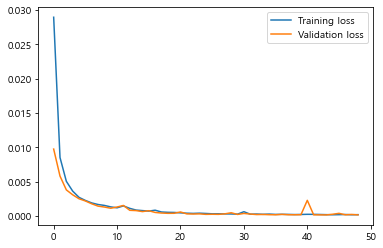

In [66]:
#fig = plt.figure(figsize=(12,5)) 16
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [68]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [69]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

### LSTM based Auto-Encode

8139/8139 [==============================] - 22s 3ms/step


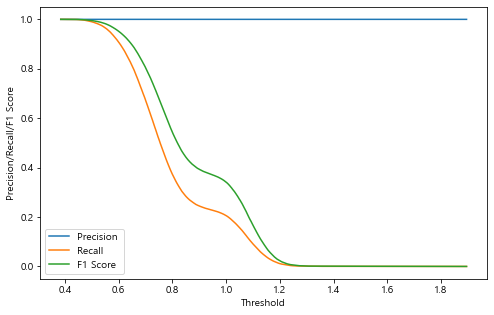

In [81]:
valid_x_predictions = lstm_ae.predict(valid_feature_auto)
mse = np.mean(np.power(flatten(valid_feature_auto) - flatten(valid_x_predictions), 2), axis=1)
mse = pd.DataFrame({'Reconstruction_error':mse})
true_valid = pd.DataFrame(valid_label_auto,columns = ['True_class'])
error_df = pd.concat([mse,true_valid] ,axis=1)

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

F1  = (2* precision_rt[1:]* recall_rt[1:])/( precision_rt[1:] +recall_rt[1:])#F1 Score 

##################################
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.plot(threshold_rt, F1, label='F1 Score ')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall/F1 Score')
plt.legend()
plt.show()

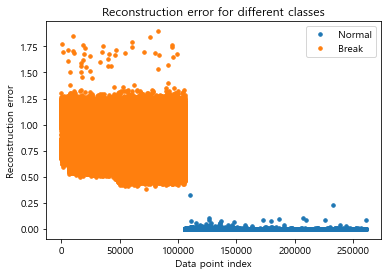

In [72]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
#ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [74]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.9999811729266685 , recall:  0.9999811729266685
threshold:  0.409525450250175


6229/6229 [==============================] - 17s 3ms/step


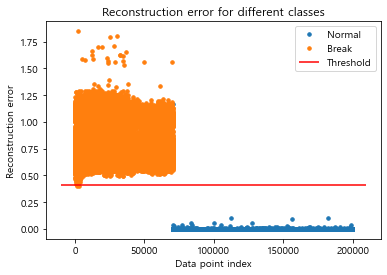

In [75]:
test_x_predictions = lstm_ae.predict(test_feature_auto)
mse = np.mean(np.power(flatten(test_feature_auto) - flatten(test_x_predictions), 2), axis=1)
mse = pd.DataFrame({'Reconstruction_error':mse})
true_test = pd.DataFrame(test_label_auto,columns = ['True_class'])
error_df = pd.concat([mse,true_test] ,axis=1)


groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

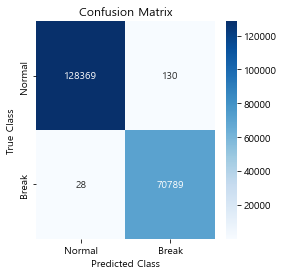

In [101]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]   #75

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(4, 4))
LABELS = ['Normal', 'Break']
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d', cmap=plt.cm.get_cmap('Blues'))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()